# Basinwide averages

This notebook makes the basinwide average plots.

In [ ]:
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot
!pip install gsw
!pip install xarray
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
#!pip install regionmask # This is currently not working v0.8
!pip install git+https://github.com/regionmask/regionmask.git

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pandas as pd
from scipy.optimize import lsq_linear
from typing import Iterable
from scipy import stats
import pyproj as proj
import scipy.interpolate as interpolate
import regionmask
import scipy.integrate as integrate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import matplotlib.font_manager
#font = {'family': 'serif', 'serif': ['Palatino'], 'size': 14}
#plt.rc('font', **font)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=False)
#plt.rc('text', usetex=False)

### Load the data

In [ ]:
# Pick which variable to use for all calculations
delv = 'delta_T_merged' # ARGO era
wodperiod='A5B7'

#delv = 'delta_T_merged_5564' # 1955-1964 climatology
#wodperiod='5564'

cutlat = -50 # most Southern Latitude to include

# LOAD THE DATA
import sys
sys.path.insert(0,'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/src')
from importlib import reload
import loadPickle as loadPickle
reload(loadPickle)
cruises_dset = loadPickle.loadPickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl', cutlat)
cruises_dset 

<xarray.Dataset>
Dimensions:                    (index: 534)
Coordinates:
  * index                      (index) int64 10 11 12 13 14 ... 615 616 617 618
Data variables: (12/40)
    Station                    (index) object '40' '40' '40' ... '181' '181'
    Date                       (index) datetime64[ns] 1874-10-08 ... 1906-08-14
    Lat degrees                (index) float64 -39.0 -39.0 -39.0 ... -9.0 -9.0
    Lat minutes                (index) float64 -9.5 -9.5 -9.5 ... -18.0 -18.0
    Lon degrees                (index) float64 20.0 20.0 20.0 ... 112.0 112.0
    Lon minutes                (index) float64 56.0 56.0 56.0 ... 9.0 9.0 9.0
    ...                         ...
    delta_T_seasonal_5564      (index) float64 -1.05 -1.454 ... -0.7273 -0.2845
    WOA_temp_seasonal_5564     (index) float64 18.15 16.85 15.55 ... 8.873 1.416
    delta_T_merged             (index) float64 -0.6061 -0.3704 ... -0.3018
    WOA_temp                   (index) float64 18.59 17.93 16.96 ... 8.995 1.398
    delta_T_merged_5564        (index) float64 -1.832 -1.609 ... -0.8942 -0.2845
    WOA_temp_5564              (index) float64 17.37 16.69 15.22 ... 8.706 1.416

In [ ]:
# LOAD GEBBIE CSV files
filename = '/content/drive/My Drive/WOD Historic Data/Jacob Analysis/GebbieAnalysis/'+'Tbar_LxyS=2000000_LxyT=450000_LzAVG=500_LzS=1000_LzT=450_sratio=0.04_tratio=2.0_σS=1.0_σobs=0.14.csv'
filename = '/content/drive/My Drive/HistoricalIndianOcean/data/best/DTbar_delta=T.csv'
df = pd.read_csv(filename)
ds_mean = df.to_xarray()
ds_mean = ds_mean.rename({'ΔT̄ [°C]':'DeltaT', 'z [m]':'z', 'σΔT̄ [°C]':'sigma'})
ds_mean


filename = '/content/drive/My Drive/HistoricalIndianOcean/data/best/DTbar_delta=T_tait.csv'
df = pd.read_csv(filename)
ds_tait = df.to_xarray()
ds_tait = ds_tait.rename({'ΔT̄ [°C]':'DeltaT', 'z [m]':'z', 'σΔT̄ [°C]':'sigma'})
ds_tait

filename = '/content/drive/My Drive/HistoricalIndianOcean/data/best/DTbar_delta=T_5564.csv'
df = pd.read_csv(filename)
ds_5564 = df.to_xarray()
ds_5564 = ds_5564.rename({'ΔT̄ [°C]':'DeltaT', 'z [m]':'z', 'σΔT̄ [°C]':'sigma'})
ds_5564

<xarray.Dataset>
Dimensions:  (index: 7)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6
Data variables:
    z        (index) int64 0 50 200 400 750 1500 2500
    DeltaT   (index) float64 0.153 -0.03354 -0.06668 ... -0.1545 -0.03517
    sigma    (index) float64 0.109 0.1057 0.09545 0.08144 0.05985 0.03826 0.0206

### LOAD SST REANALYSES

#### HADLEY

Unzipping contents of '/root/.cache/regionmask/natural_earth/v5.0.0/ne_50m_geography_marine_polys.zip' to '/root/.cache/regionmask/natural_earth/v5.0.0/ne_50m_geography_marine_polys'
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


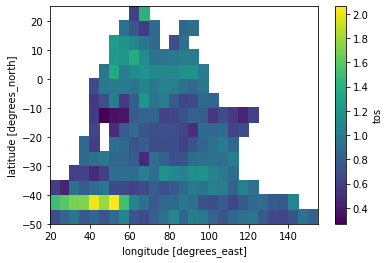

In [ ]:
dhad = xr.open_dataset('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/HadSST.4.0.1.0_median.nc')

# First do a quick cutting down of the data
dhad = dhad.where((dhad.latitude>=cutlat)&(dhad.latitude<30)&(dhad.longitude>10)&(dhad.longitude<180), drop=True) # limit to the correct hemisphere

dslice = slice(cruises_dset.Date.min(), cruises_dset.Date.max())
hadanom = dhad.sel(time=slice('2005-01-01T12:00:00.000000000','2018-01-01T12:00:00.000000000')).tos.mean('time') - dhad.sel(time=dslice).tos.mean('time')
hadanom_5564 = dhad.sel(time=slice('1955-01-01T12:00:00.000000000','1965-01-01T12:00:00.000000000')).tos.mean('time') - dhad.sel(time=dslice).tos.mean('time')

# Mask data by the natural earth regional mask
#rmask = regionmask.defined_regions.natural_earth.ocean_basins_50.mask(hadanom, lat_name='latitude', lon_name='longitude')
rmask = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50.mask(hadanom, lat_name='latitude', lon_name='longitude')

regions = [5, 13, 52, 10, 36]#Together these define the IO

hadanom_dir = hadanom.where(rmask.isin(regions), drop=True)
hadanom_5564_dir = hadanom_5564.where(rmask.isin(regions), drop=True)
hadanom_dir.plot()

# We also need to calculate the area of each cell for weighted averaging
LAT, LON = np.meshgrid(hadanom_dir.latitude, hadanom_dir.longitude)

dlon = hadanom_dir.longitude.diff(dim='longitude')[0].values
dlat = hadanom_dir.latitude.diff(dim='latitude')[0].values

dy = dlat*111e3 + 0*LAT
dx = dlon*111e3*np.cos(LAT*np.pi/180)
dAh = dy*dx # This is in meters^2.

In [ ]:
#  # If needed to see the Natural Earth Regions for choosing the domain:
#  plt.figure(figsize=(12,12))
# # regionmask.defined_regions.natural_earth.ocean_basins_50.plot_regions()
#  regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50.plot_regions()

#  plt.ylim(-60, 30)
#  plt.xlim(20, 150)
#  regions = [5, 13, 52, 10, 36]

#### ERASST

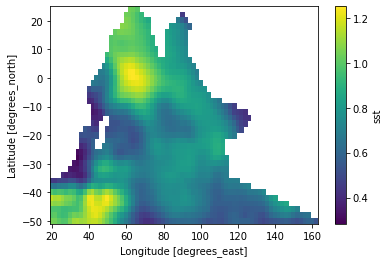

In [ ]:
ersst = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst/sst.mnmean.v4.nc')
ersst = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc')

ersst = ersst.where((ersst.lat>=cutlat)&(ersst.lat<30)&(ersst.lon>10)&(ersst.lon<180), drop=True) # limit to the correct hemisphere

dslice = slice(cruises_dset.Date.min(), cruises_dset.Date.max())
ersstanom = ersst.sel(time=slice('2005-01-01T12:00:00.000000000','2018-01-01T12:00:00.000000000')).sst.mean('time') - ersst.sel(time=dslice).sst.mean('time')
ersstanom_5564 = ersst.sel(time=slice('1955-01-01T12:00:00.000000000','1965-01-01T12:00:00.000000000')).sst.mean('time') - ersst.sel(time=dslice).sst.mean('time')

rmask = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50.mask(ersstanom, lat_name='lat', lon_name='lon')

ersstanom_dir = ersstanom.where(rmask.isin(regions), drop=True)
ersstanom_5564_dir = ersstanom_5564.where(rmask.isin(regions), drop=True)

ersstanom_dir.plot()

LAT, LON = np.meshgrid(ersstanom_dir.lat, ersstanom_dir.lon)

dlon = np.abs(ersstanom_dir.lon.diff(dim='lon')[0].values)
dlat = np.abs(ersstanom_dir.lat.diff(dim='lat')[0].values)

dy = dlat*111e3 + 0*LAT
dx = dlon*111e3*np.cos(LAT*np.pi/180)
dAe = dy*dx

## START ANALYSIS

In [ ]:
# Need to pick bin sizes for averaging 
bins = [-1, 1, 100, 300, 500, 1000, 2000, 3000]

In [ ]:
# group data by bins
binned_data = cruises_dset.groupby_bins('Depth', bins=bins, right=True, include_lowest=True).mean() 

# group data by bins
binned_median = cruises_dset.groupby_bins('Depth', bins=bins, right=True, include_lowest=True).median() 

# Tait pressure corr
tait = binned_data.WOA_temp - (binned_data.Temperature - 0.04*binned_data.Depth/1000)


## Make Plot

Surface temperature delta: [ 0.87128389  0.69702151  0.3663804   0.2272715   0.03385173 -0.13311493
 -0.0448234 ] degrees
Surface temperature error: [0.21798785 0.21136536 0.19090866 0.16288342 0.11970073 0.07652161
 0.04120096] degrees
Tait error range: [ 1.0895345   0.91060132  0.56573316  0.40705328  0.18458584 -0.00631616
  0.13644389] degrees


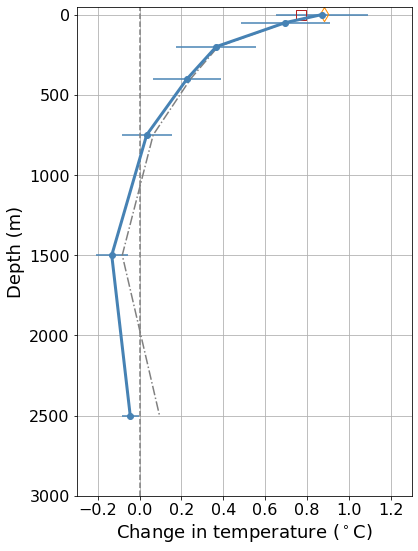

In [ ]:
fig1, ax1 = plt.subplots(figsize=(6,9))

# Flag changes limits and turns on/off SST reanalyses markers
# 'historic' here means using the 19555-1964 climatology (instead of ARGO)
historic = False

x = binned_data[delv]
y = binned_data['Depth']


ax1.set_ylim(3000,-50)
#ax1.set_xlim(-0.6,0.8)
ax1.errorbar(ds_mean.DeltaT, ds_mean.z, xerr=2*ds_mean.sigma, fmt='-o', c= 'steelblue', label='Simple mean', linewidth=3, elinewidth=1.5)
#ax1.plot(x,y, c='steelblue', linewidth=3)
#ax1.plot(dsoptdiff, dsopt_m.depth)
#if not historic:
ax1.plot(ds_tait.DeltaT, ds_tait.z, c='0.5', label='Tait corr.', linestyle='-.')

#ax1.plot(binned_median[delv], y, c='0.5', marker='|', markersize=10, linestyle='')
ax1.set_xlabel(u'Change in temperature ($^\circ$C)', fontsize=18)
ax1.set_ylabel('Depth (m)', fontsize=18)

plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)
#ax1.xaxis.grid(True)
ax1.axvline(0.0, linestyle='--', c='grey')

if not historic:
  #ax1.scatter(np.nanmean(hada), 0, marker='o', s=100, label='HAD-Track')
  maskH = np.isfinite(hadanom_dir.values)
  ax1.scatter(np.nansum(hadanom_dir.values[maskH]*dAh.T[maskH])/np.nansum(dAh.T[maskH]), 0, marker='d',color='none', edgecolors='darkorange', s=100, zorder=2)
  maskE = np.isfinite(ersstanom_dir.values)
  ax1.scatter(np.nansum(ersstanom_dir.values[maskE]*dAe.T[maskE])/np.nansum(dAe.T[maskE]), 0, marker='s', color='none', edgecolors='firebrick', s=100, zorder=2)


plt.grid()
if historic:
  plt.xlim(-0.8, 0.8)
else:
  plt.xlim(-.3, 1.3)
print(f'Surface temperature delta: {ds_mean.DeltaT[:].values} degrees')
print(f'Surface temperature error: {2*ds_mean.sigma.values} degrees')
print(f'Tait error range: {ds_tait.DeltaT[:].values + 2*ds_tait.sigma[:].values} degrees')

plt.savefig('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/Profile_3cruise_'+'A5B7'+'.pdf', bbox_inches='tight')

Surface temperature delta: [ 0.15300044 -0.03354457 -0.06668288  0.01169447 -0.19631835 -0.15447602
 -0.03517057] degrees


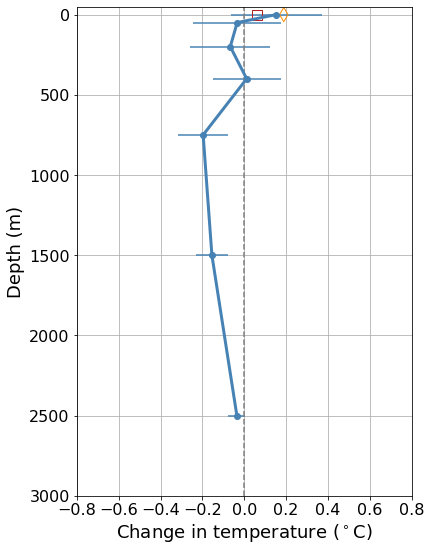

In [ ]:
fig1, ax1 = plt.subplots(figsize=(6,9))

# Flag changes limits and turns on/off SST reanalyses markers
# 'historic' here means using the 19555-1964 climatology (instead of ARGO)
historic = True

x = binned_data[delv]
y = binned_data['Depth']


ax1.set_ylim(3000,-50)
#ax1.set_xlim(-0.6,0.8)
ax1.errorbar(ds_5564.DeltaT, ds_mean.z, xerr=2*ds_5564.sigma, fmt='-o', c= 'steelblue', label='Simple mean', linewidth=3, elinewidth=1.5)
#ax1.plot(x,y, c='steelblue', linewidth=3)

#if not historic:
  #ax1.plot(tait, y, c='mediumseagreen', label='Tait corr.')

#ax1.plot(binned_median[delv], y, c='0.5', marker='|', markersize=10, linestyle='')
ax1.set_xlabel(u'Change in temperature ($^\circ$C)', fontsize=18)
ax1.set_ylabel('Depth (m)', fontsize=18)

plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)
#ax1.xaxis.grid(True)
ax1.axvline(0.0, linestyle='--', c='grey')

maskH = np.isfinite(hadanom_5564_dir.values)
ax1.scatter(np.nansum(hadanom_5564_dir.values[maskH]*dAh.T[maskH])/np.nansum(dAh.T[maskH]), 0, marker='d',color='none', edgecolors='darkorange', s=100, zorder=2)
maskE = np.isfinite(ersstanom_5564_dir.values)
ax1.scatter(np.nansum(ersstanom_5564_dir.values[maskE]*dAe.T[maskE])/np.nansum(dAe.T[maskE]), 0, marker='s', color='none', edgecolors='firebrick', s=100, zorder=2)


plt.grid()
if historic:
  plt.xlim(-0.8, 0.8)
else:
  plt.xlim(-0.3, 1.1)
print(f'Surface temperature delta: {ds_5564.DeltaT[:].values} degrees')
plt.savefig('/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/Profile_3cruise_'+'5564'+'.pdf', bbox_inches='tight')

## CALCULATE OHC using Jake's estimates of change


In [ ]:
# Modern Era
DeltaOHC = 49*10**21 # Updated Modern OHC change
Sigma = 11*10**21

CruiseAvgYear = cruises_dset.where(cruises_dset.Depth > 700, drop=True).Date.mean().values.astype('datetime64[Y]').astype(int) + 1970
numdecades = (np.mean(np.arange(2005, 2018)) - CruiseAvgYear)/10

print(f'Change per decade: {DeltaOHC/numdecades/10**22}')
print(f'2 sigma: {2*Sigma/numdecades/10**22}')


In [ ]:
DeltaOHC =  -7*10**21 # Updated Modern OHC change
Sigma = 11*10**21

CruiseAvgYear = cruises_dset.where(cruises_dset.Depth > 700, drop=True).Date.mean().values.astype('datetime64[Y]').astype(int) + 1970
numdecades = (np.mean(np.arange(1955, 1965)) - CruiseAvgYear)/10

print(f'Change per decade: {DeltaOHC/numdecades/10**22}')
print(f'2 sigma: {2*Sigma/numdecades/10**22}')